In [15]:
import math
import numpy as np
from matplotlib import pyplot as g
import random
from  graphviz import Digraph

In [182]:
class Scalar:
    def __init__(self, value, label = '', oprt = '', children = tuple()):
        self.value = value
        self.label = label
        self.oprt  = oprt
        self.children = set(children)
        self.der = 0.0

        self._backward = lambda: None # Initialize to empty function

    def __repr__(self):
        return f"Scalar({self.value}, {self.der})"

    # double underscore method (dunder)
    def __add__(self, other):

        # Forward pass: What to do during an addition operation
        if type(other) == type(1.0) or type(other) == type(1):
            other = Scalar(other)
            
        label = f"{self.label}+{other.label}"
            
        out = Scalar(self.value + other.value, label=label, oprt = '+',  children=(self, other))

        def backward():
            # This is how we will back propagate the derivatives of output
            # that was created as the result of addition

            # Use += because we would like to accumulate the derivatives
            # because same Scalar can appear in multiple terms in the Math expression
            self.der  += 1.0 * out.der
            other.der += 1.0 * out.der

        # function assignment
        out._backward = backward

        return out


    def __mul__(self, other):
        if type(other) == type(1.0) or type(other) == type(1):
            other = Scalar(other)
            
        label = f"{self.label}*{other.label}"

        out = Scalar(self.value * other.value, label=label, oprt = '*', children=(self, other))

        def backward():
            self.der  += out.der * other.value
            other.der += out.der * self.value


        out._backward = backward

        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def tanh(self):
        # Implement tanh
        out = Scalar(np.tanh(self.value), oprt='tanh', children=(self, ))

        def backward():
            self.der += (1 - out.value ** 2) * out.der

        out._backward = backward
        
        return out

    def __pow__(self, other):

        out = Scalar(self.value ** other, oprt='**', children=(self,))

        def backward():
            self.der += (other * (self.value ** (other-1))) * out.der

        out._backward = backward
        return out
        
    def __neg__(self):
        self.value = -1 * self.value
        return self
        
    def __sub__(self, other):
        out = Scalar(self.value - other.value, oprt='-', children=(self, other))
        return out

    def __truediv__(self, other):
        if type(other) == type(1.0):
            out = Scalar(self.value / other, oprt = '/', children=(self, other))
        else:
            out = Scalar(self.value / other.value, oprt = '/', children=(self, other))
        return out

    def backward(self):
        # topologically sort all nodes from this node onwards/downwards
        visited = set()
        topo = [] # ordering of nodes
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                # I am finished with v only AFTER I am finished with all its children
                # I can wear belt only after wearing trousers and underwear before it
                for child in v.children:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.der = 1
        for v in reversed(topo):
            v._backward()
        

In [183]:
a = Scalar(2.0, label='a')
b = Scalar(3.0, label='b')
c = a ** 4; c.label='c'
d = c + b; d.label ='d'
# 
# dd/da = dd/dc dc/da = 1. 2

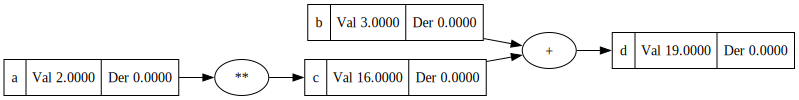

In [184]:
draw_graph(d)

In [185]:
d.der = 1.0
d.backward()

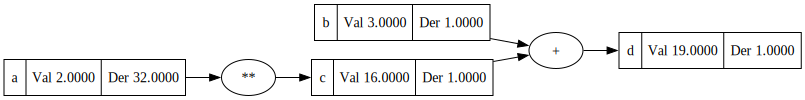

In [186]:
draw_graph(d)

In [122]:
def trace(root):
    nodes = set()
    edges = set()
 
    def build(v):
        if v not in nodes:
            nodes.add(v)
            
            for child in v.children:
                edges.add((child, v))
                build(child)

    build(root)   
    
    return nodes, edges

In [123]:
def draw_graph(root, format='svg', rankdir='LR'):
    nodes, edges = trace(root)
    
    graph = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for n in nodes:
        graph.node(name=str(id(n)), label = "{ %s | Val %.4f | Der %.4f }" % (n.label, n.value, n.der), shape='record')
        if n.oprt:
            graph.node(name=str(id(n)) + n.oprt, label=n.oprt)
            graph.edge(str(id(n)) + n.oprt, str(id(n)))
    
    for n1, n2 in edges:
        graph.edge(str(id(n1)), str(id(n2)) + n2.oprt)
    
    return graph

In [52]:
# Inputs
x1 = Scalar(2.0, label = 'x1')
x2 = Scalar(0.0, label = 'x2')

# Weights
w1 = Scalar(-3.0, label = 'w1')
w2 = Scalar(1.0, label = 'w2')

# bias
b = Scalar(6.88137458701, label = 'bias')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

s = x1w1 + x2w2; s.label = 'sum'

o = s + b; o.label = 'o'

L = o.tanh(); L.label = 'L'


In [53]:
L.der = 1.0
L.backward()

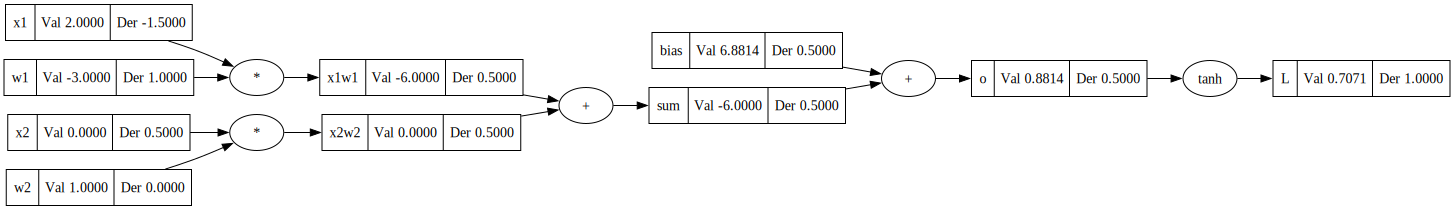

In [54]:
draw_graph(L)

## Neural Network = Specific class of Mathematical Expressions!

In [187]:
# Training set, you can X and y
# X is a vector, x1, x2,... xn
class Neuron:
    
    # CTOR
    def __init__(self, n_inputs):
        self.weights = [Scalar(random.uniform(-1,1)) for _ in range(n_inputs)]
        self.bias = Scalar(random.uniform(-1,1))

    def __call__(self, x):
        act = sum(xi * wi for xi, wi in zip(x, self.weights)) + self.bias
        out = act.tanh()
        return out

    @property
    def parameters(self):
        return self.weights + [self.bias]
    

In [188]:
class Layer:
    # CTOR
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        # Get output of each neuron by calling that neuron with input x
        outputs = [n(x) for n in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

    @property
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters]

In [189]:
class MLP:
    def __init__(self, n_in, n_out):
        #                        0  1  2  3
        size = [n_in] + n_out # [3, 4, 4, 1] 3 inputs, 1 output and 4 neurons in 1st and 2nd layer
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(n_out))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) # layer.__call__(x)

        return x

    @property
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters]

In [190]:
xs = [
    [2.0, 3.0, -1.5], # first input x1, x2, x3
    [1.5, 2.0, 4.1],
    [3.5, 1, 0.5],
    [3.0, 2.0, 1.4]
]
ys = [Scalar(1.0), Scalar(-1.0), Scalar(-1.0), Scalar(1.0)] # 4 labels / y actual

In [191]:
nn = MLP(3, [4, 4, 1])

In [192]:
len(nn.parameters)

41

In [107]:
# Homework : Find out how 41 is related to 3 and [4,4,1]

In [108]:
# draw_graph(nn(xs[0])) # shows the computation graph

In [193]:
ypred = [nn(x) for x in xs]

In [194]:
ypred

[Scalar(0.24508266345401314, 0.0),
 Scalar(0.3070253484878854, 0.0),
 Scalar(0.3223188907067719, 0.0),
 Scalar(0.27963704082795254, 0.0)]

In [195]:
loss = sum((yp - ya) ** 2 for ya, yp in zip(ys, ypred))

In [196]:
loss

Scalar(4.545665488274662, 0.0)

In [134]:
nn.layers[0].neurons[0].weights[1].der

0.0

In [197]:
loss.der = 1.0

In [135]:
# We have just done only forward pass 
# There is NO back propagation yet

In [198]:
loss.backward()

In [199]:
nn.layers[0].neurons[0].weights[0].der

0.0

In [201]:
nn.layers[0].neurons[1].weights[1].value

0.4498154927467557

In [ ]:
nn.layers[0].neurons[0].weights[1].value +=  -0.01 * nn.layers[0].neurons[0].weights[1].der

In [93]:
ypred = [nn(x) for x in xs]

In [202]:
# update
for p in nn.parameters:
    p.value += -0.01 * p.der if p.der > 0 else 0.01 * p.der

In [143]:
ypred

[Scalar(-0.7795245025134366, 0.0),
 Scalar(-0.6619042695563672, 0.0),
 Scalar(-0.7775847045227253, 0.0),
 Scalar(-0.767715603431565, 0.0)]

In [144]:
loss = sum((yp - ya) ** 2 for ya, yp in zip(ys, ypred))

In [145]:
loss

Scalar(6.4553031962675735, 0.0)

In [206]:
'''
Single iteration or epoch

Forward pass

    Predict output values (ypred) based on MLP / Neural Network = Math expression

    Calcualte loss (compare predicted values with actual values)

Backward pass (Back propagation)

    Missing step  (initialization of derivatives to 0)
    Update all derivatives (gradients)
    loss.backward()

Update all parameters

    param.value += learning rate * param.derivative

'''

for k in range(100):

    # fwd pass
    ypred = [nn(x) for x in xs]
    loss = sum((yp - ya) ** 2 for ya, yp in zip(ys, ypred))

    # backward pass

    for p in nn.parameters:
        p.der = 0.0
    # back propagation of all derivatives 
    # starting from the output / L
    
    loss.backward()

    # update
    for p in nn.parameters:
        p.value += -0.05 * p.der if p.der > 0 else 0.05 * p.der


    print(f"{k}) {loss.value}")


0) 4.545665488274662
1) 4.545665488274662
2) 4.545665488274662
3) 4.545665488274662
4) 4.545665488274662
5) 4.545665488274662
6) 4.545665488274662
7) 4.545665488274662
8) 4.545665488274662
9) 4.545665488274662
10) 4.545665488274662
11) 4.545665488274662
12) 4.545665488274662
13) 4.545665488274662
14) 4.545665488274662
15) 4.545665488274662
16) 4.545665488274662
17) 4.545665488274662
18) 4.545665488274662
19) 4.545665488274662
20) 4.545665488274662
21) 4.545665488274662
22) 4.545665488274662
23) 4.545665488274662
24) 4.545665488274662
25) 4.545665488274662
26) 4.545665488274662
27) 4.545665488274662
28) 4.545665488274662
29) 4.545665488274662
30) 4.545665488274662
31) 4.545665488274662
32) 4.545665488274662
33) 4.545665488274662
34) 4.545665488274662
35) 4.545665488274662
36) 4.545665488274662
37) 4.545665488274662
38) 4.545665488274662
39) 4.545665488274662
40) 4.545665488274662
41) 4.545665488274662
42) 4.545665488274662
43) 4.545665488274662
44) 4.545665488274662
45) 4.54566548827466